<a href="https://colab.research.google.com/github/irinagetman1973/Vehicle-tracking-in-challenging-scenarios-using-YOLOv8/blob/Colab-updates/Custom_video_track_and_count_with_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 <center>
  <img src="https://user-images.githubusercontent.com/22610163/30512919-72a57046-9b02-11e7-8ca8-c3e4bd993497.gif">
</center>



# YOLOv8 Tracking (and Counting)

---


Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.



## Pro Tip:  GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps 



- Check your GPU
- Download video
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video





Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon May 15 23:02:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. This notebook works with version **YOLOv8.0.17**.


In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.17

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.17 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.8/78.2 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install loguru

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
!pip install lap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Tracking video

In [ ]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Auckland-vehicles-12_05/IMG_4505.MP4"

# Get the base name of the video
base_name = os.path.basename(SOURCE_VIDEO_PATH)

# Split the base name into name and extension 
name, extension = os.path.splitext(base_name)

## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

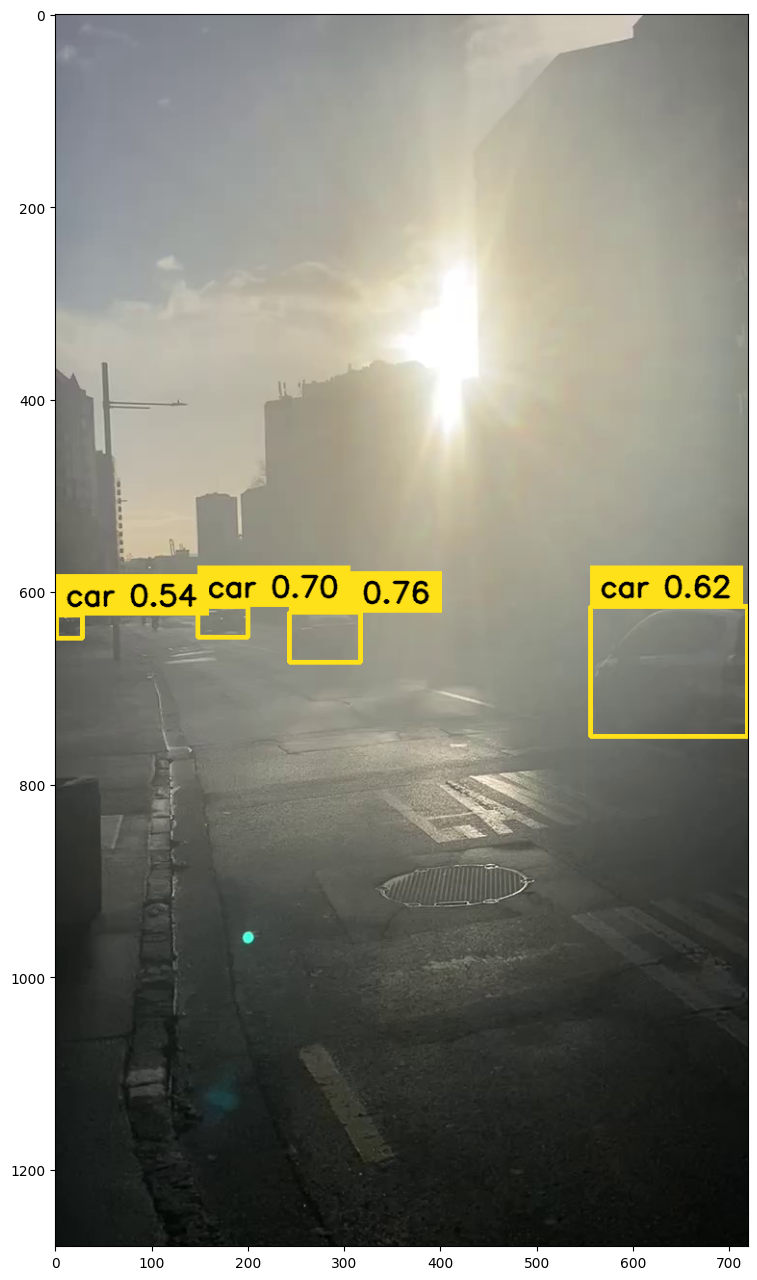

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=2, text_scale=1)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))


## Predict and annotate whole video 

In [ ]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

# Create the output video path
TARGET_VIDEO_PATH = os.path.join( '/content/drive/MyDrive/Auckland-vehicles-12_05/vehicle-counting-results', name + "_result" + extension)


In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=720, height=1280, fps=29, total_frames=675)

### Description of the following code

**video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH):** This line creates a VideoInfo instance from the source video file. The VideoInfo class is used to store information about a video, like its width, height, duration, frame rate, etc. The from_video_path function is a class method that creates a VideoInfo instance by reading the video file at SOURCE_VIDEO_PATH.

**generator = get_video_frames_generator(SOURCE_VIDEO_PATH):** This line creates a generator that yields the frames of the source video one by one. This allows the code to process the video frame by frame without loading the entire video into memory at once.

**box_annotator* = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2):** This line creates an instance of BoxAnnotator, which is a class that's used to draw bounding boxes and labels on frames. The bounding boxes represent the detected objects, and the labels contain information about the detected objects (like their class name and detection confidence).

**with VideoSink(TARGET_VIDEO_PATH, video_info) as sink**: This line opens a VideoSink, which is a class used to write video frames to a file. The VideoSink is opened in a with block, which ensures that it gets properly closed after the block is finished, even if an error occurs within the block. The frames that are written to the VideoSink will be saved to a video file at TARGET_VIDEO_PATH.

The **for** loop **for frame in tqdm(generator, total=video_info.total_frames):** iterates over each frame in the source video. The tqdm function is used to display a progress bar that shows how many frames have been processed.

Within the loop, the **model(frame)** line runs the object detection model on the current frame, and the Detections class is used to store the detected objects. The detections are filtered to remove unwanted classes, and then labels are generated for each detection. The labels contain the class name of the detected object and the detection confidence.

The **box_annotator.annotate(frame=frame, detections=detections, labels=labels)** line draws the bounding boxes and labels on the frame.

The **sink.write_frame(frame)** line writes the annotated frame to the target video file. This is done for each frame in the source video, so the target video file will contain a copy of the source video with bounding boxes and labels drawn on it.

In [ ]:
from tqdm.notebook import tqdm

# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, _
            in detections
        ]
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        sink.write_frame(frame)


  0%|          | 0/691 [00:00<?, ?it/s]

### Counting and Detecting video

The following code is for processing a video file and tracking objects in it, while annotating them with boxes and other relevant information, such as tracker ID, class name, and confidence score.

1. Import tqdm library 


2. Create instances of the following classes:

 * BYTETracker for tracking objects in the video.

 * VideoInfo to obtain information about the source video.

 * A frame generator that yields individual frames from the source video. 
 *  LineCounter to count the number of objects passing through a specified line.

 * BoxAnnotator to draw bounding boxes around detected objects.
 * LineCounterAnnotator to annotate the frame with the line counter information.

3. Open a target video file using the VideoSink context manager, which takes care of opening and closing the video file.

4. Iterate over the frames of the source video using a for loop, and for each frame:

    a.  Run the model on the current frame to obtain object detection results.

    b. Convert the results to a Detections object with bounding box coordinates, confidence scores, and class IDs.

    c. Filter out unwanted class IDs.

    d. Update the BYTETracker with the current frame's detection results.

    e. Match detections with their corresponding tracks using the match_detections_with_tracks function.

    f. Filter out detections without trackers.

    g. Create custom labels for each detection with tracker ID, class name, and confidence score.

    h. Update the LineCounter with the current frame's detections.

    i. Annotate the frame with bounding boxes using the BoxAnnotator and with the line counter information using the LineCounterAnnotator.

    j. Write the annotated frame to the target video file.



In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

### This code is adapted from the following repository:
https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8.ipynb


 <center>
  <img src="https://64.media.tumblr.com/d0635fa4e4bf417b33f24bd481c21f88/tumblr_ppcabrYCWy1ue08b9o1_540.gifv ">
</center>

## Data loading and preprocessing for training a YOLO model from scratch

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ffIk56k2V8LObD6n9fDp")
project = rf.workspace("roboflow-100").project("vehicles-q0x2v")
dataset = project.version(2).download("yolov8")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=cc426a30c5411c522c213a0a5ca6e4aad478a920004b253f52f40d3021524967
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics<=8.0.20`, to intall it `pip install ultralytics<=8.0.20`.


Extracting Dataset Version Zip to vehicles-2 in yolov8:: 100%|██████████| 8128/8128 [00:01<00:00, 6180.57it/s]
